In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col"),
    ]
)

COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [102]:
def generate_fancy_plots(
    df: pd.DataFrame, 
    adv_name: str,
    highlighted_victim_steps = None,
    skip_legend: bool = False,
    custom_legend_label: str = "",
    custom_xlabel: str | None = None,
    custom_ylabel: str | None = None,
    vv_filter: list[int] | None = None,
    x_axis_column = "victim_steps",
    line_style = "solid",
):
    """Generate plot of adv win rate (y-axis) vs. victim training time (x-axis)."""
    ALPHA = 0.05
    for i, vv in enumerate(sorted(df.victim_visits.unique())):
        if vv_filter is not None and vv not in vv_filter:
            continue

        sub_df = df.query(
            "&".join(
                [
                    "victim_visits == @vv",
                    "adv_name == @adv_name",
                ]
            )
        )
        mean_df = sub_df.groupby(x_axis_column).adv_win.mean()

        (100 * mean_df).plot(
            label=(None if skip_legend else f"{custom_legend_label}{vv}"), 
            color=COLORS[i],
            linestyle=line_style
        )

        # Compute Clopper-Pearson confidence intervals
        ci_df = sub_df.groupby(x_axis_column).adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(
            ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
        )
        ci_df = 100 * ci_df
        plt.fill_between(
            mean_df.index,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            color=COLORS[i],
            edgecolor="none",
        )

        if highlighted_victim_steps:
            highlighted_row = sub_df.query("victim_steps == @highlighted_victim_steps")
            plt.plot(
                highlighted_row[x_axis_column].mean(),
                100 * highlighted_row.adv_win.mean(),
                "D",
                color=COLORS[i],
                alpha=0.7,
            )
    # Legend in lower left corner
    if not skip_legend:
        plt.legend()
    plt.ylabel(
        custom_ylabel or r"Win rate \%"
    )
    plt.xlabel(custom_xlabel or rf"KataGo training steps")

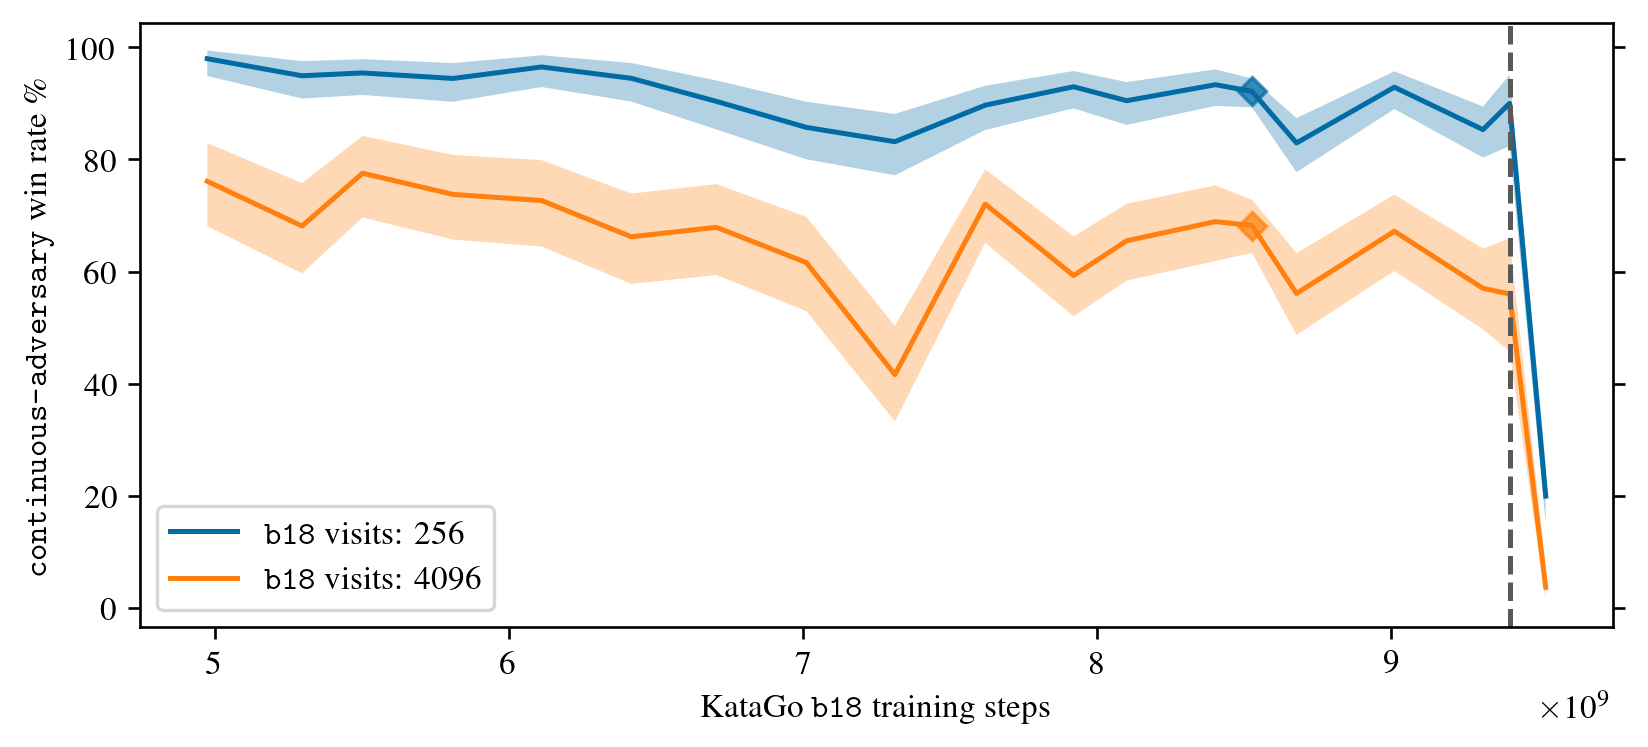

In [92]:
# TODO regen when cont sweeps finish
df = utils.parse_sgfs(["/shared/match/ttseng-cont-sweeps-240313/b18-ckpts"])
generate_fancy_plots(
    df, 
    adv_name="adv-s630461952-v600-AMCTS",
    highlighted_victim_steps=8526915840,
    custom_legend_label=r"\texttt{b18} visits: ",
    custom_xlabel=r"KataGo \texttt{b18} training steps",
    custom_ylabel=r"\texttt{continuous-adversary} win rate \%",
)
# Lightvector added some of our positions from an earlier version of this adversary into the
# KataGo training data and says the checkpoint s9432 is the first one that may have seen
# the positions.
ADV_TRAINING_START_STEPS = 9402410496
plt.axvline(
    ADV_TRAINING_START_STEPS,
    color=COLORS[3],
    linestyle="--",
)
plt.show()

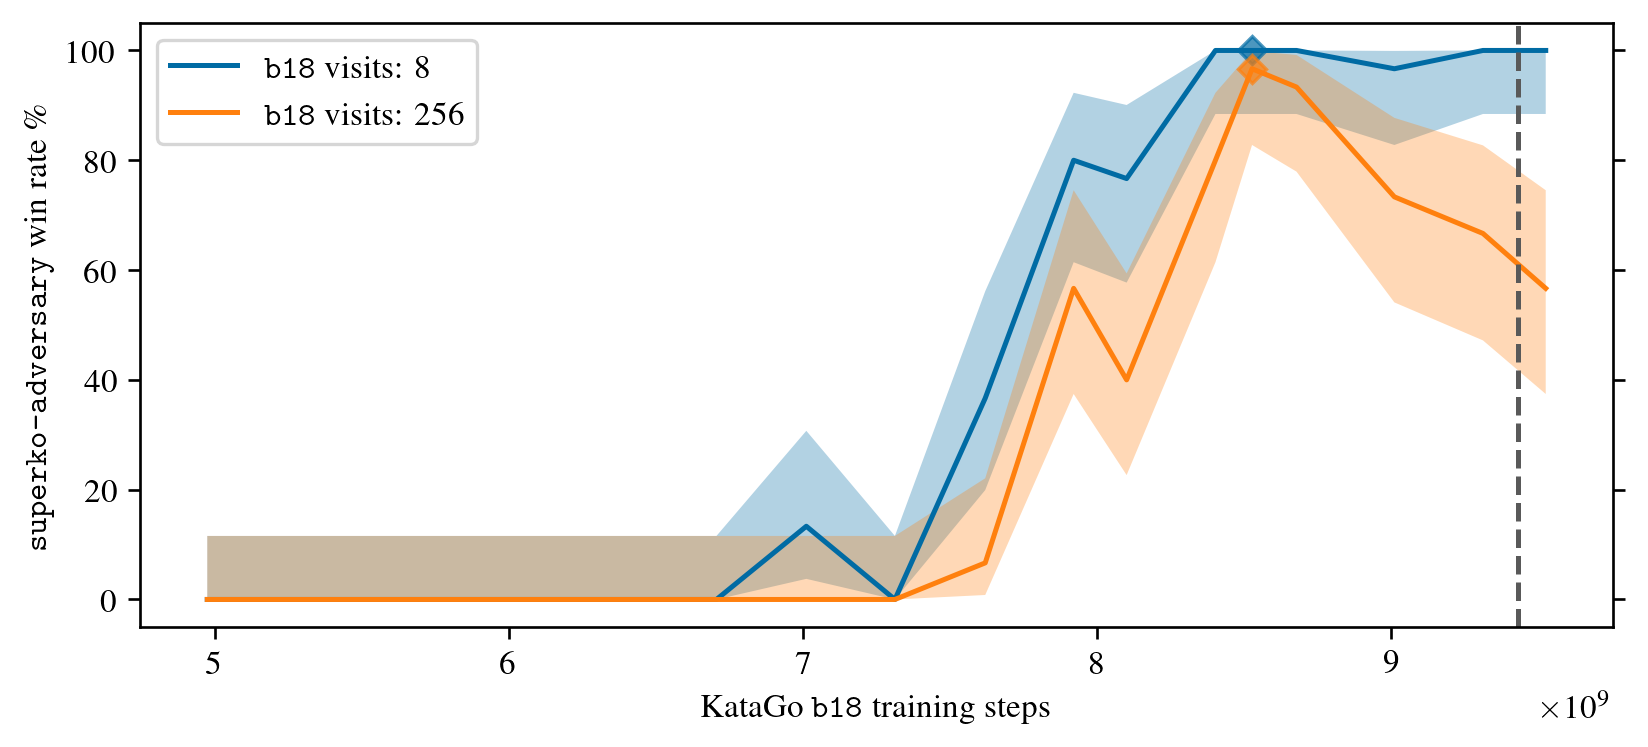

In [90]:
# TODO regen when run final eval
df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-sweeps-240329/prelim-b18-ckpts"])
generate_fancy_plots(
    df, 
    adv_name="adv-s216098048-v600-AMCTS",
    highlighted_victim_steps=8526915840,
    custom_legend_label=r"\texttt{b18} visits: ",
    custom_xlabel=r"KataGo \texttt{b18} training steps",
    custom_ylabel=r"\texttt{superko-adversary} win rate \%",
)
ADV_TRAINING_START_STEPS = 9402410496
plt.axvline(
    ADV_TRAINING_START_STEPS,
    color=COLORS[3],
    linestyle="--",
)
plt.show()

In [4]:
def swap_adv_and_victim(df: pd.DataFrame):
    to_swap = ["color", "name", "visits", "steps", "rsym", "algo"]
    for col in to_swap:
        col1 = f"victim_{col}"
        col2 = f"adv_{col}"
        df[col1], df[col2] = df[col2], df[col1]
    nums_to_negate = ["adv_komi", "adv_minus_victim_score", "adv_minus_victim_score_wo_komi"]
    for col in nums_to_negate:
        df[col] = -df[col]
    df["adv_win"] = ~df["adv_win"]

def cached_get_v100_gpu_days(
    training_path: Path,
) -> dict[int, float]:
    """Returns the estimated V100 GPU-days for each adv checkpoint."""
    selfplay_path = training_path / "selfplay"
    cache_file = selfplay_path / "steps_to_v100_gpu_days.log"
    if not cache_file.exists():
        raise RuntimeError(f"Run cached_get_v100_gpu_days() in robustness-estimate-gpu-days-adv.ipynb first to generate {cache_file}")
    with open(cache_file) as f:
        steps_to_gpu_days = json.load(f)
    return { int(steps): gpu_days for steps, gpu_days in steps_to_gpu_days.items()}

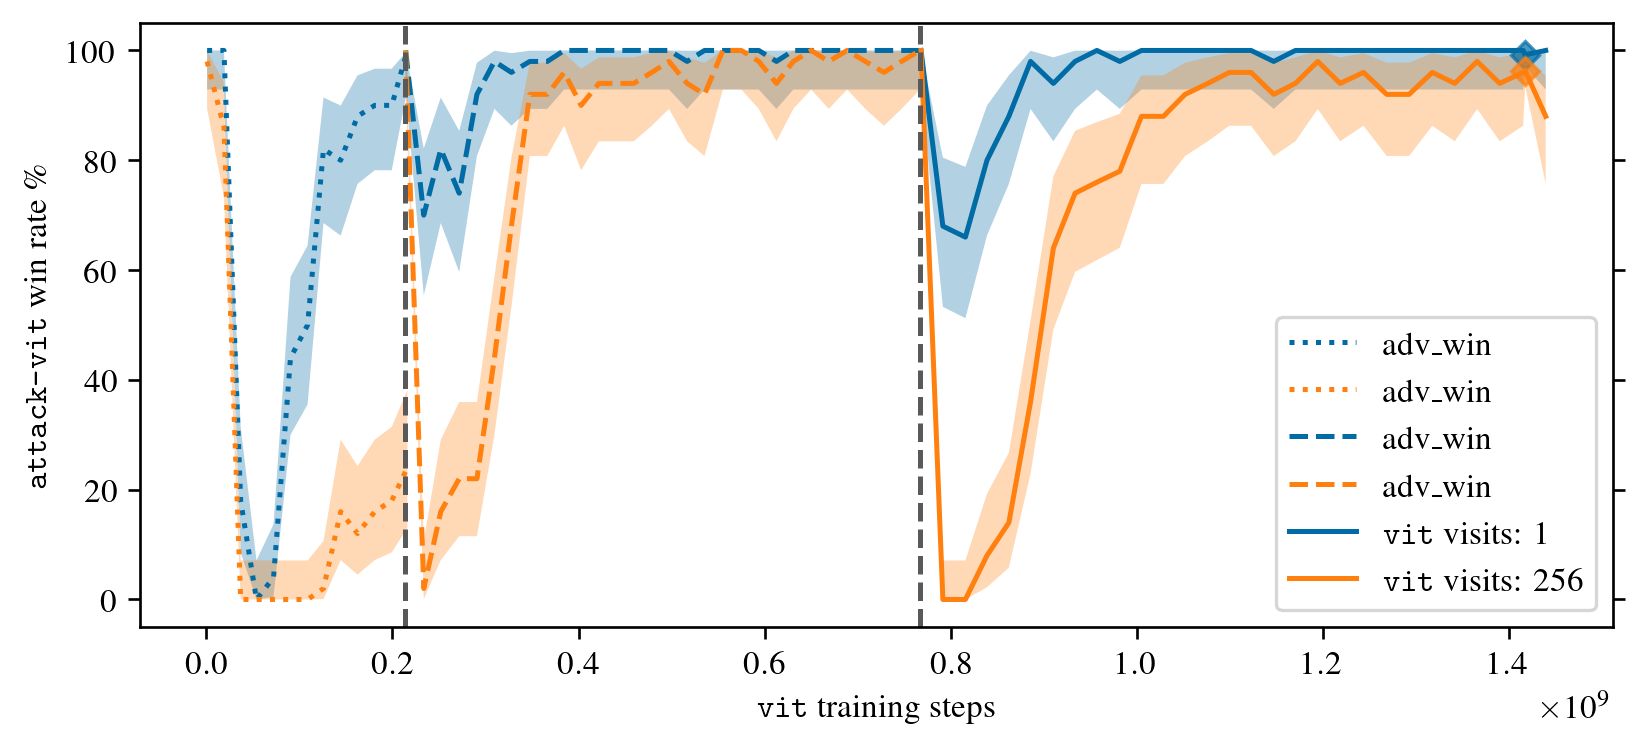

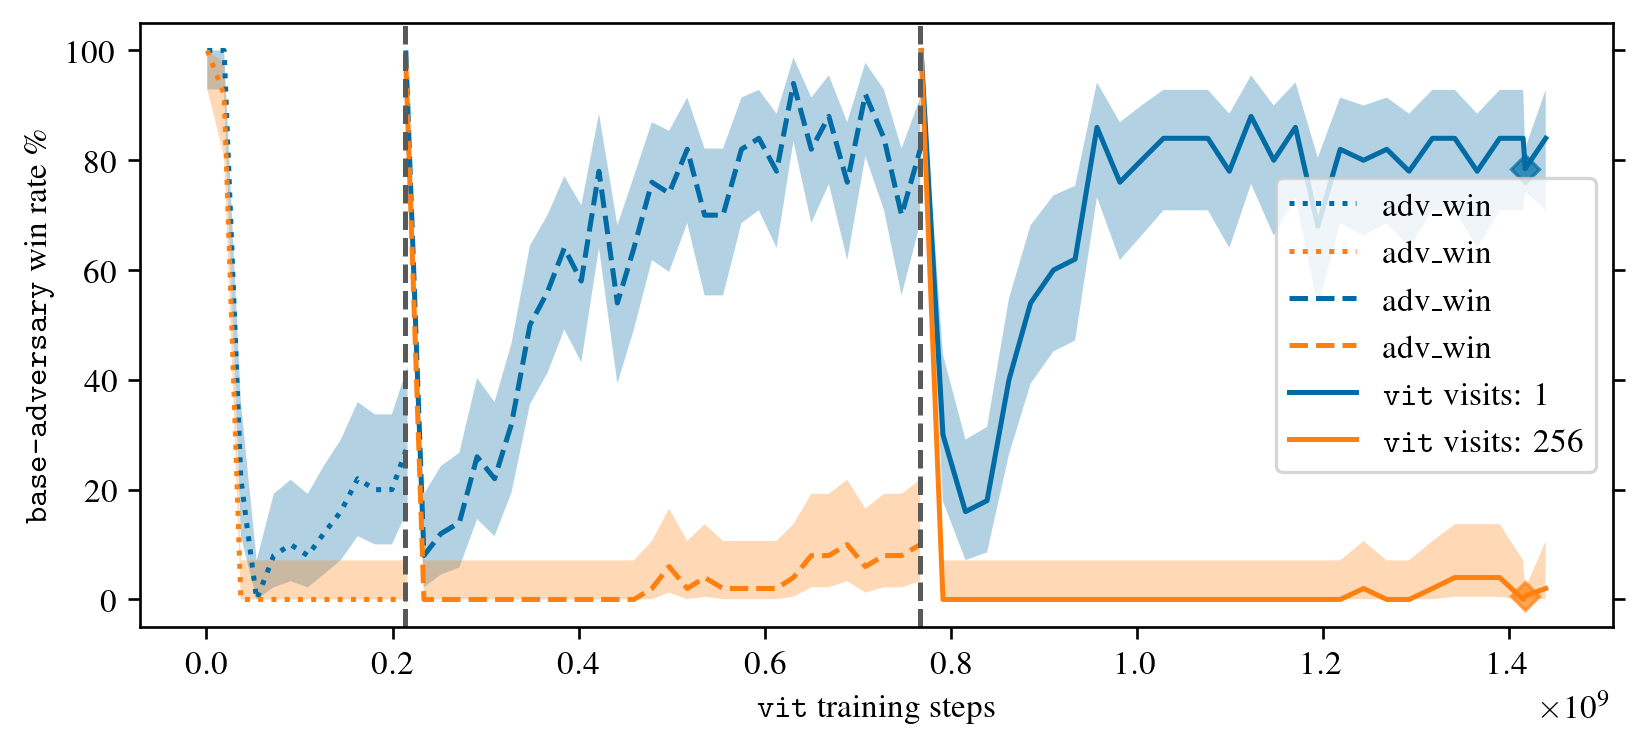

In [104]:
VIT_B4_MAX_STEPS = 213218816
VIT_B8_MAX_STEPS = 553885440
VIT_B16_MAX_STEPS = 650025472

vit_df = utils.parse_sgfs(
    f"/shared/match/ttseng-vit-selfplay-240314/{name}"
    for name in ["vit-b4", "vit-b8", "vit-b16"]
)
# Adversaries and victims are swapped in these data, let's unswap everything
swap_adv_and_victim(vit_df)

vit_df["victim_architecture"] = vit_df["sgf_path"].str.split("/").str[4]
vit_df["original_victim_steps"] = vit_df["victim_steps"]
# vit-b4 nets above s217m are bad. but we have one net slightly above VIT_B4_MAX_STEPS, 
# and below s217m, we'll include it in the plot because I forgot to eval VIT_B4_MAX_STEPS
vit_df = vit_df[(vit_df["victim_architecture"] != "vit-b4") | (vit_df["victim_steps"] <= 217500000)]
# Show vit-b4, vit-b8, and vit-b16 sequentially
vit_df.loc[vit_df["victim_architecture"] == "vit-b8", "victim_steps"] += VIT_B4_MAX_STEPS
vit_df.loc[vit_df["victim_architecture"] == "vit-b16", "victim_steps"] += VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS

architecture_to_line_style = {
    "vit-b4": "dashdot",
    "vit-b8": "dashed",
    "vit-b16": "solid",
}

for adv_name, adv_label in [
    ("attack-vit-s326m", r"\texttt{attack-vit}"),
    ("cyclic-s545m", r"\texttt{base-adversary}"),
]:
    # Plot different architectures separately so that their lines
    # aren't connected.
    for i, (architecture, line_style) in enumerate(architecture_to_line_style.items()):
        highlighted_steps = VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS + VIT_B16_MAX_STEPS if architecture == "vit-b16" else None
        generate_fancy_plots(
            vit_df[vit_df["victim_architecture"] == architecture], 
            adv_name=adv_name,
            highlighted_victim_steps=highlighted_steps,
            skip_legend=(i != len(architecture_to_line_style) - 1),
            custom_legend_label=r"\texttt{vit} visits: ",
            custom_xlabel=r"\texttt{vit} training steps",
            custom_ylabel=f"{adv_label} win rate \%",
            line_style=line_style,
        )
    # We don't want legend entries for each plotted line, just keep two legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles[-2:], labels=labels[-2:], loc="lower right", bbox_to_anchor=(1, 0))
    
    for step in [ VIT_B4_MAX_STEPS, VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS ]:
        plt.axvline(x=step, linestyle=":", color=COLORS[3])
    plt.show()

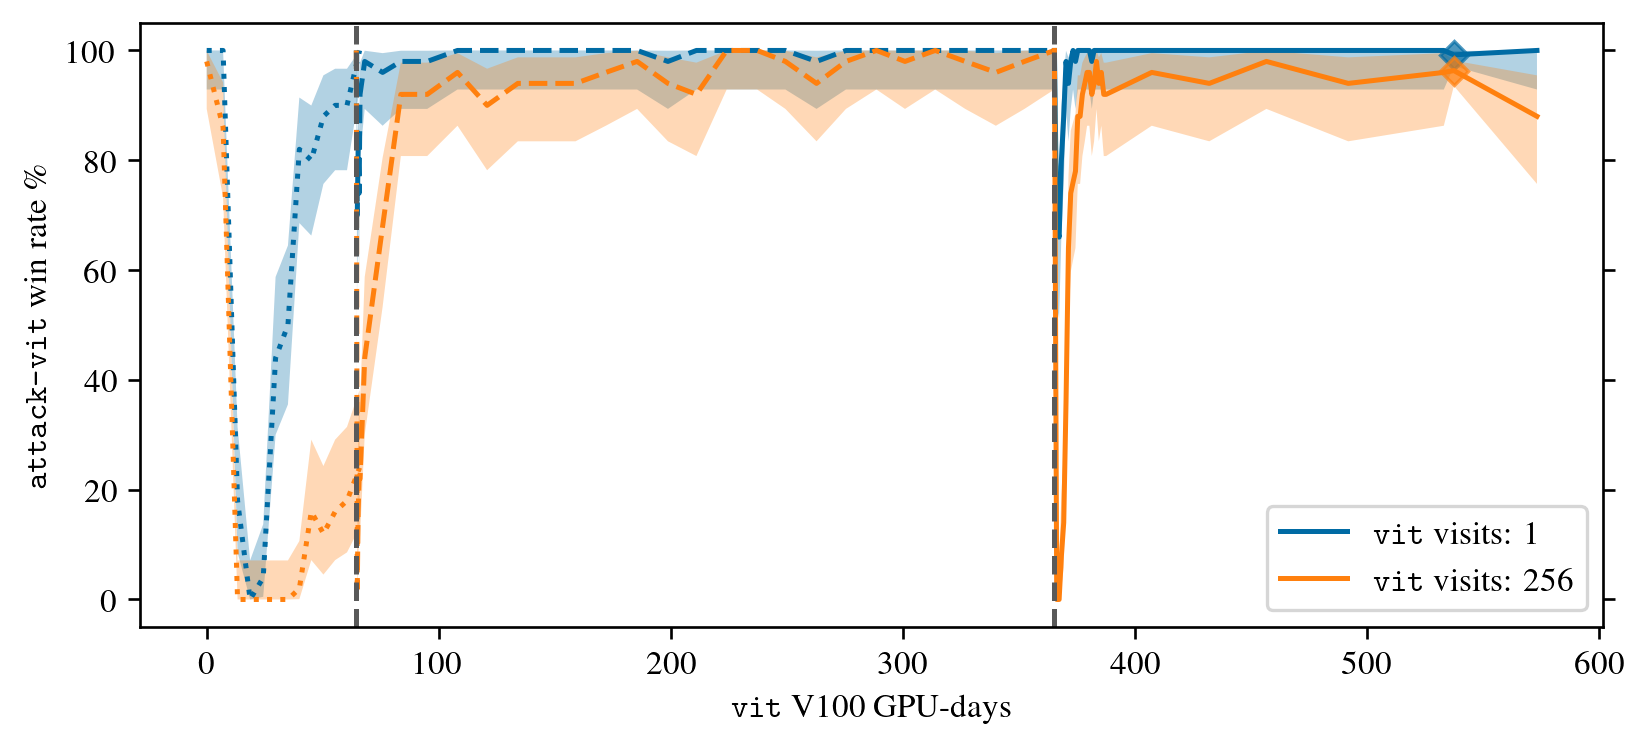

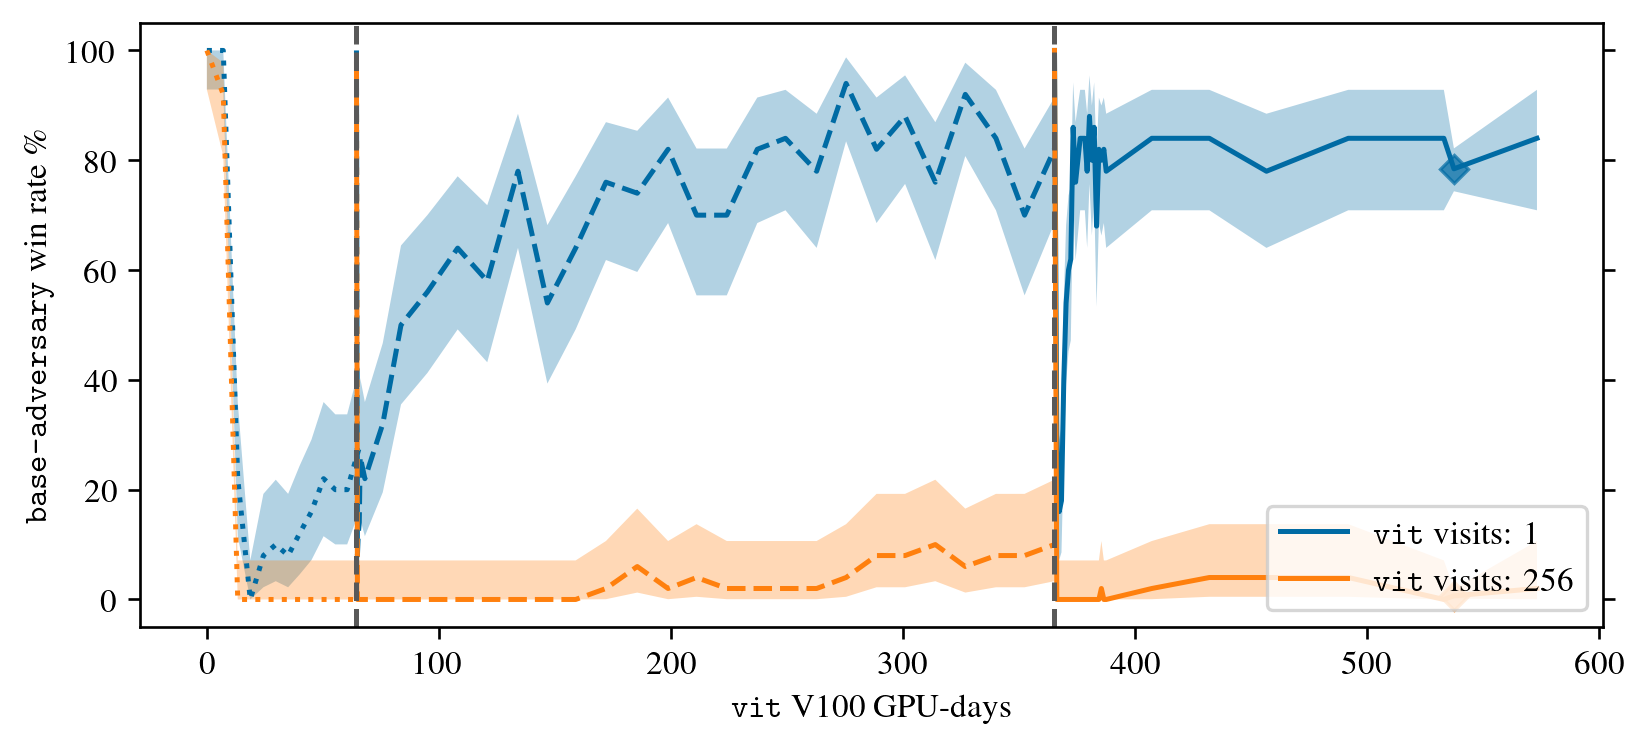

In [106]:
gpu_days_conversions = {
    architecture: cached_get_v100_gpu_days(Path("/shared/victimplay") / path)
    for architecture, path in [
        ("vit-b4", "ttseng-vitp2b4c384-selfplay-231031"),
        ("vit-b8", "ttseng-vitp2b8c384-selfplay-231106"),
        ("vit-b16", "ttseng-vitp2b16c384-minrows10m-240103"),
    ]
}

# All GPU-days need to be scaled down to estimate the cost had we trained with
# FP16 instead of FP32.
# Also, vit-b8 and vit-b16 had a pre-training phase, and vit-b16 warmstarted
# from another pre-training-only preliminary vit-b16 run.
gpu_days_conversions["vit-b4"] = {
    steps: gpu_days * 0.4921424391 + 2.746 * (steps / VIT_B4_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b4"].items()
}
gpu_days_conversions["vit-b8"] = {
    steps: gpu_days * 0.4449017465 + 11.627 * (steps / VIT_B8_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b8"].items()
}

vit_b16_pre_warmstart_steps_list = utils.get_all_adversary_steps(Path("/shared/victimplay/ttseng-vitp2b16c384-selfplay-231124"))
vit_b16_warmstart_steps = min(gpu_days_conversions["vit-b16"].keys())
gpu_days_conversions["vit-b16"].update({
    steps: 0 
    for steps in vit_b16_pre_warmstart_steps_list
    if steps <= vit_b16_warmstart_steps
})
gpu_days_conversions["vit-b16"] = {
    steps: gpu_days * 0.3364575545 + 27.618 * (steps / VIT_B16_MAX_STEPS)
    for (steps, gpu_days) in gpu_days_conversions["vit-b16"].items()
}

vit_df['victim_gpu_days'] = vit_df.apply(lambda row: gpu_days_conversions[row["victim_architecture"]][row["original_victim_steps"]], axis=1)

vit_b4_gpu_days = gpu_days_conversions["vit-b4"][VIT_B4_MAX_STEPS]
vit_b8_gpu_days = gpu_days_conversions["vit-b8"][VIT_B8_MAX_STEPS]
# Show vit-b4, vit-b8, and vit-b16 sequentially
vit_df.loc[vit_df["victim_architecture"] == "vit-b8", "victim_gpu_days"] += vit_b4_gpu_days
vit_df.loc[vit_df["victim_architecture"] == "vit-b16", "victim_gpu_days"] += vit_b4_gpu_days + vit_b8_gpu_days

for adv_name, adv_label in [
    ("attack-vit-s326m", r"\texttt{attack-vit}"),
    ("cyclic-s545m", r"\texttt{base-adversary}"),
]:
    # Plot different architectures separately so that their lines
    # aren't connected.
    for i, (architecture, line_style) in enumerate(architecture_to_line_style.items()):
        highlighted_steps = VIT_B4_MAX_STEPS + VIT_B8_MAX_STEPS + 650025472 if architecture == "vit-b16" else None
        generate_fancy_plots(
            vit_df[vit_df["victim_architecture"] == architecture], 
            adv_name=adv_name,
            highlighted_victim_steps=highlighted_steps,
            skip_legend=(i != len(architecture_to_line_style) - 1),
            custom_legend_label=r"\texttt{vit} visits: ",
            custom_xlabel=r"\texttt{vit} V100 GPU-days",
            custom_ylabel=f"{adv_label} win rate \%",
            x_axis_column="victim_gpu_days",
            line_style=line_style,
        )
    # We don't want legend entries for each plotted line, just keep two legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles[-2:], labels=labels[-2:], loc="lower right", bbox_to_anchor=(1, 0))
    
    for gpu_days in [ vit_b4_gpu_days, vit_b4_gpu_days + vit_b8_gpu_days ]:
        plt.axvline(x=gpu_days, linestyle=":", color=COLORS[3])
    plt.show()

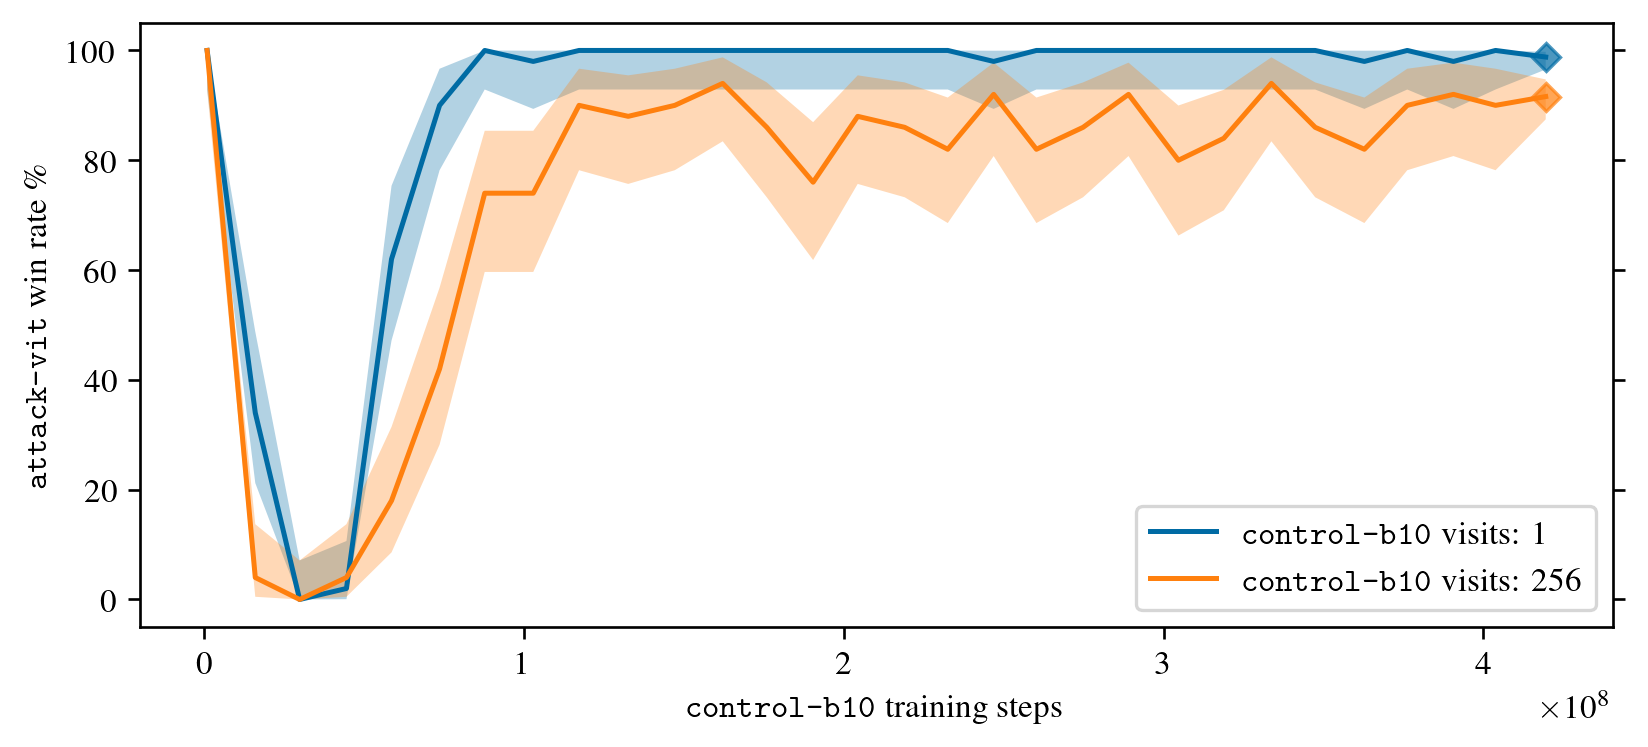

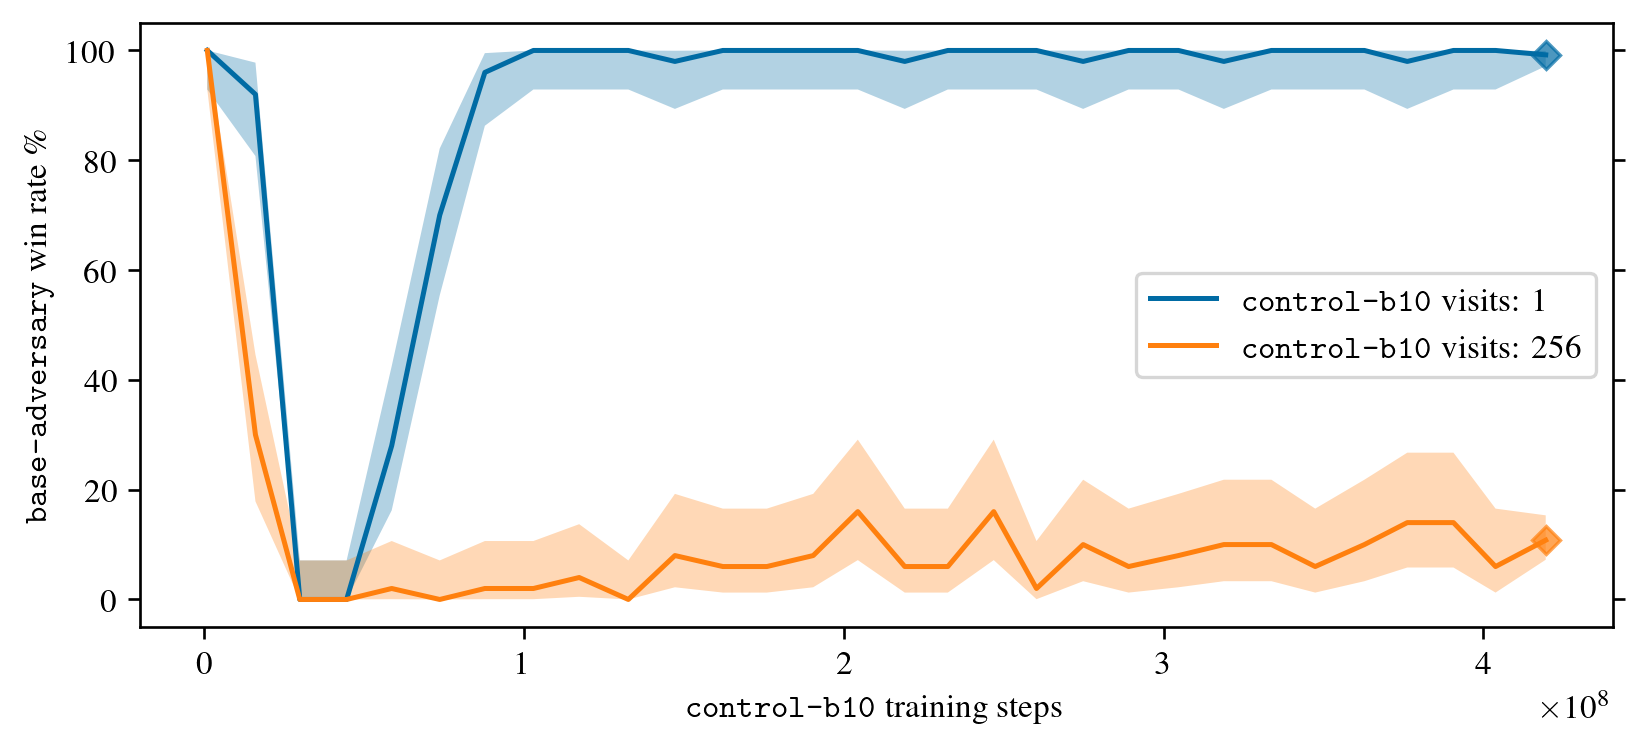

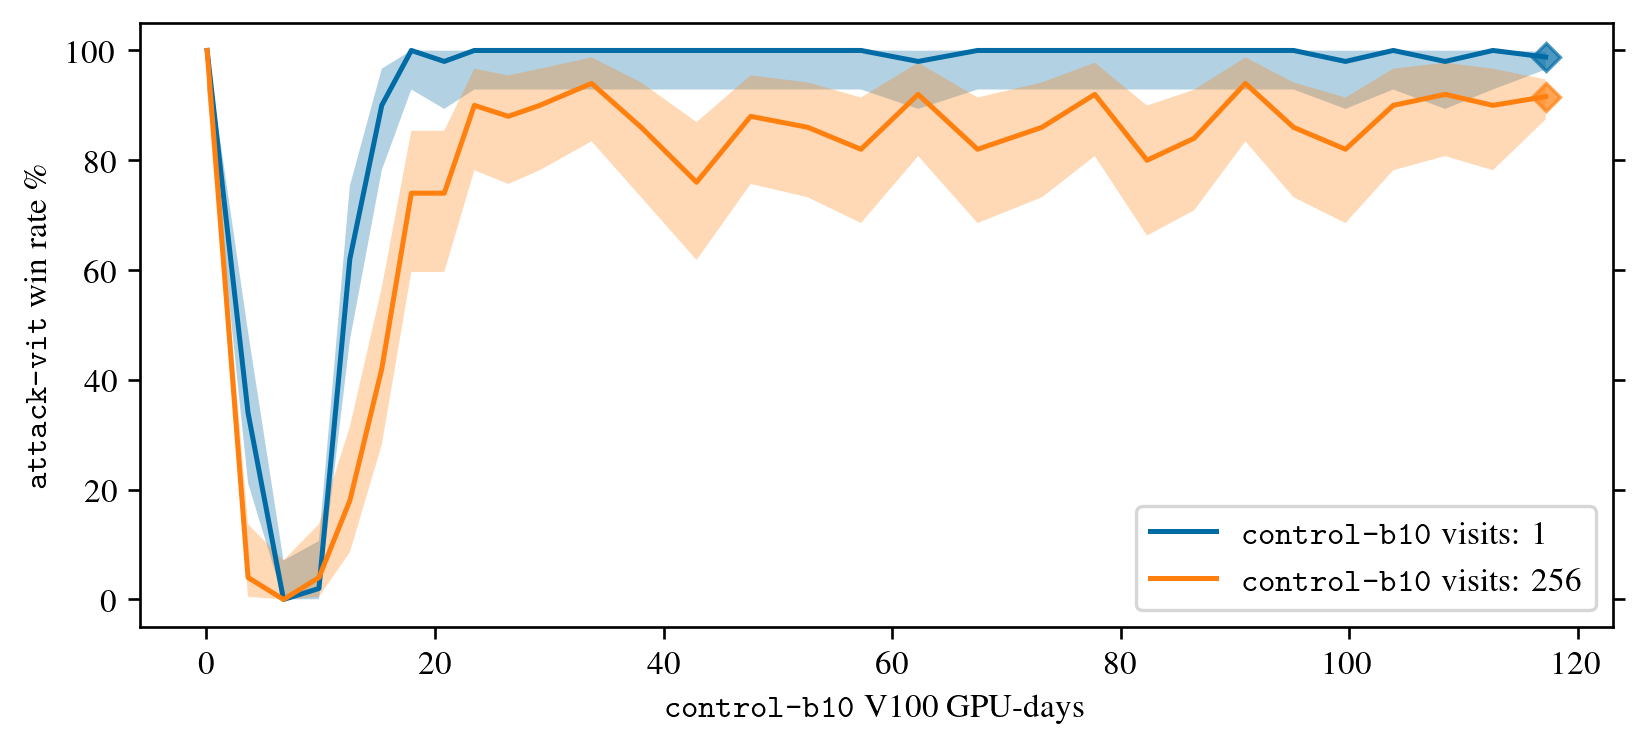

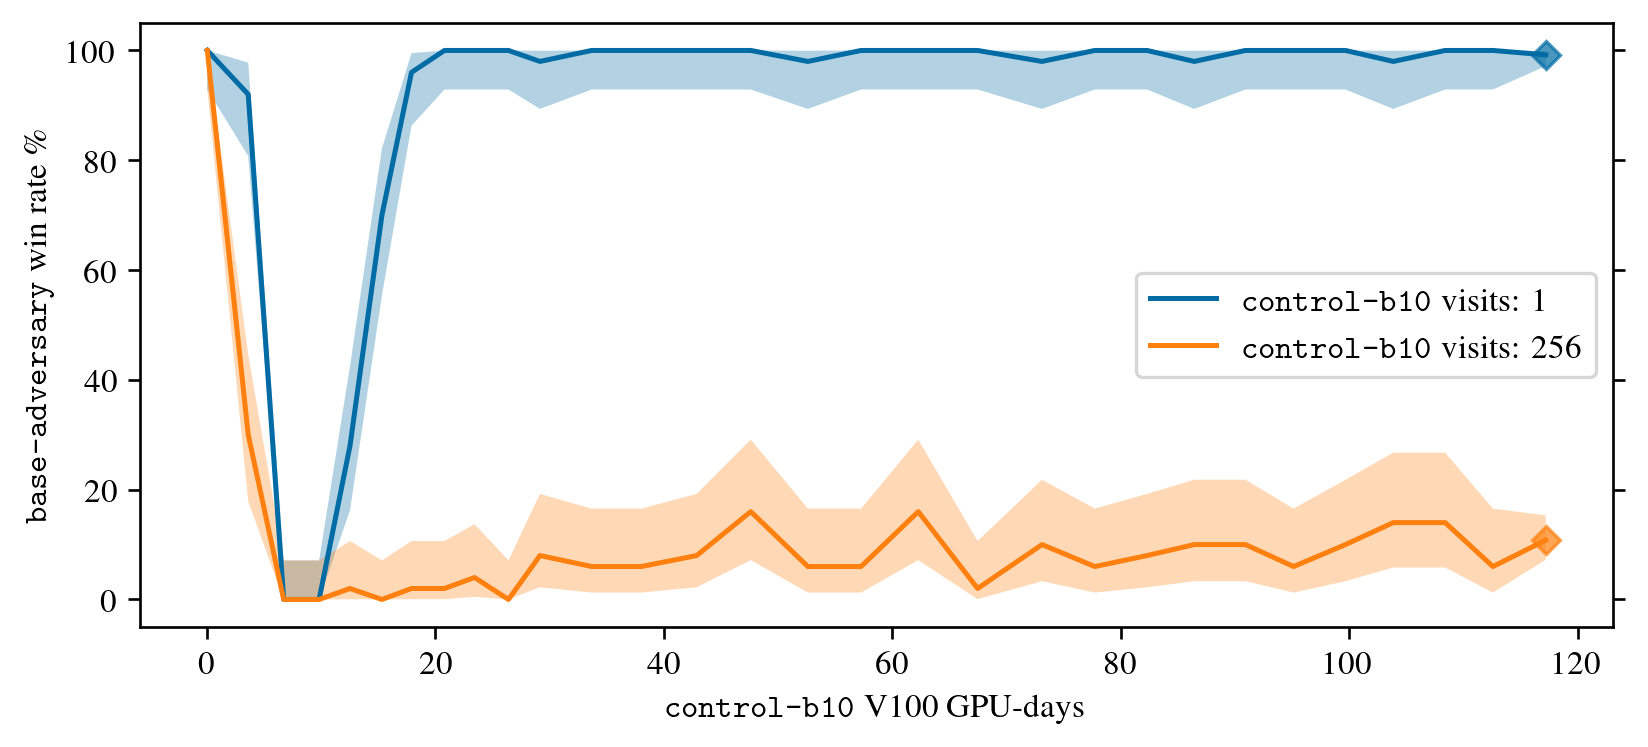

In [26]:
b10_df = utils.parse_sgfs(["/shared/match/ttseng-vit-selfplay-240314/b10"])
swap_adv_and_victim(b10_df)
steps_to_gpu_days = cached_get_v100_gpu_days(Path("/shared/victimplay/ttseng-b10-selfplay-231026"))
gpu_days_conversions["b10"] = steps_to_gpu_days
b10_df["victim_architecture"] = "b10"
b10_df["original_victim_steps"] = b10_df["victim_steps"]
b10_df['victim_gpu_days'] = b10_df.apply(lambda row: steps_to_gpu_days[row["victim_steps"]], axis=1)

for x_axis_column, x_label in [
    ("victim_steps", "training steps"),
    ("victim_gpu_days", "V100 GPU-days"),
]:
    for adv_name, adv_label in [
        ("attack-vit-s326m", r"\texttt{attack-vit}"),
        ("cyclic-s545m", r"\texttt{base-adversary}"),
    ]:
        generate_fancy_plots(
            b10_df, 
            adv_name=adv_name,
            highlighted_victim_steps=419465984,
            custom_legend_label=r"\texttt{control-b10} visits: ",
            custom_xlabel=rf"\texttt{{control-b10}} {x_label}",
            custom_ylabel=f"{adv_label} win rate \%",
            x_axis_column=x_axis_column,
        )
        plt.show()

## Elo

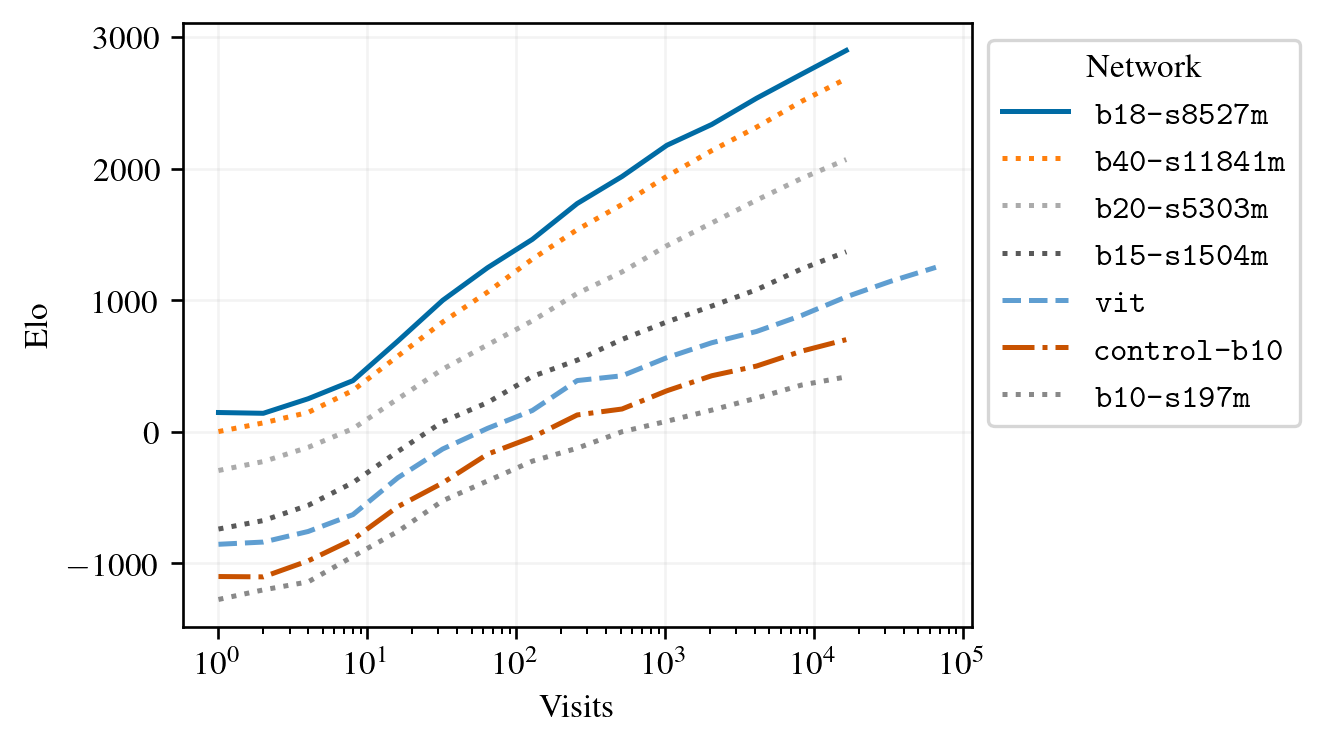

In [96]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(fig.get_figwidth() * 0.8) # Make main figure squarish.
plt.subplot(1, 1, 1)

match_path = Path("/shared/ttseng/robustness-elo.txt")
lines = match_path.read_text().splitlines()
elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

bot_entries: list[dict[str, float | int | str]] = []
baseline_elo = 0
steps_regex = re.compile("-s(\d+)")
for elo_line in elo_lines:
    name = elo_line.split(":")[0].strip()
    steps_match = re.search(steps_regex, name)
    entry = {
        "name": name,
        "model": name.split("-v")[0],
        "architecture": name.split("-")[0] if steps_match is None else name.split("-s")[0],
        "steps": None if steps_match is None else int(steps_match.group(1)),
        "visits": int(name.split("-v")[1]),
        "elo": float(elo_line.split(":")[1].split("+/-")[0]),
        "stddev": float(elo_line.split("+/-")[1]),
    }
    bot_entries.append(entry)
    if name == "cp505-v1":
        baseline_elo = entry["elo"]
# Transpose all Elo scores so that baseline_elo is at 0.
for entry in bot_entries:
    entry["elo"] -= baseline_elo

# mapping of models to show on Elo plots to (label name, line style)
# Non-adversarially trained conv nets = dotted
# Adversarially trained conv nets = solid
# ViT = dashed
shown_models = {
    "b18-s8527m": (r"\texttt{b18-s8527m}", "solid"),
    "cp505": (r"\texttt{b40-s11841m}", "dotted"),
    "cp127": (r"\texttt{b20-s5303m}", "dotted"),
    "cp103": (r"\texttt{b15-s1504m}", "dotted"),
    "vit-b16-s650025472": (r"\texttt{vit}", "dashed"),
    "b10-s419465984": (r"\texttt{control-b10}", "dashdot"),
    "cp79": (r"\texttt{b10-s197m}", "dotted"),
}

elo_df = pd.DataFrame(bot_entries)
for model, (label, line_style) in shown_models.items(): 
    data_by_visits = elo_df[elo_df["model"] == model].groupby("visits").mean(numeric_only=True)
    data_by_visits.elo.plot(label=label, linestyle=line_style)
    # plt.fill_between(data_by_visits.index, data_by_visits.elo - data_by_visits.stddev, data_by_visits.elo + data_by_visits.stddev, alpha=0.3)
plt.ylabel("Elo")
plt.xlabel("Visits")
plt.xscale("log")

plt.legend(
    title="Network",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fancybox=True,
)

utils.filter_x_minor_ticks()
plt.gca().grid(True, alpha=0.15)

# Remove ticks from the right
plt.gca().yaxis.set_ticks_position("left")

plt.savefig("elo-by-visits.pgf", backend="pgf")

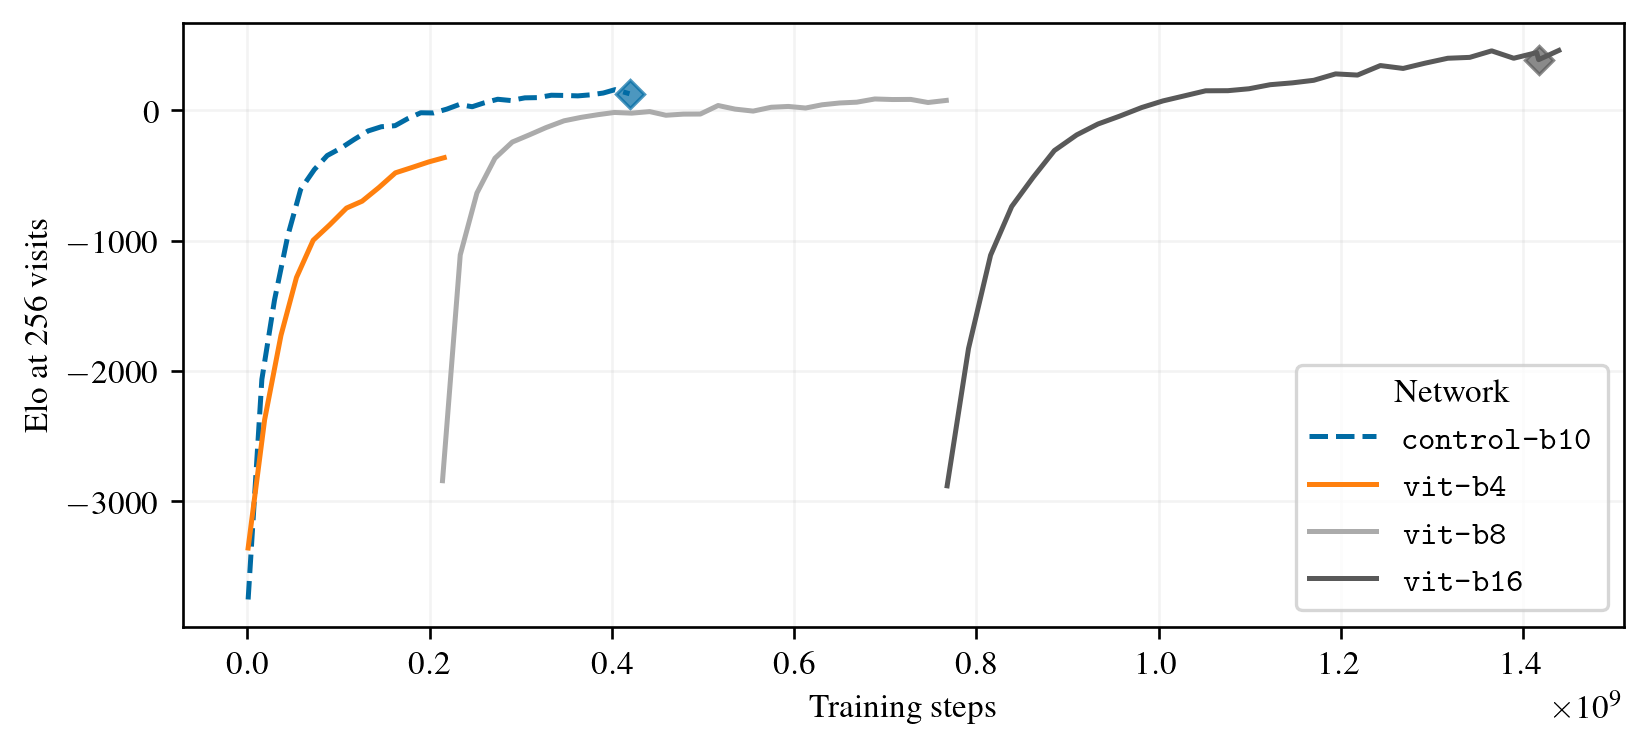

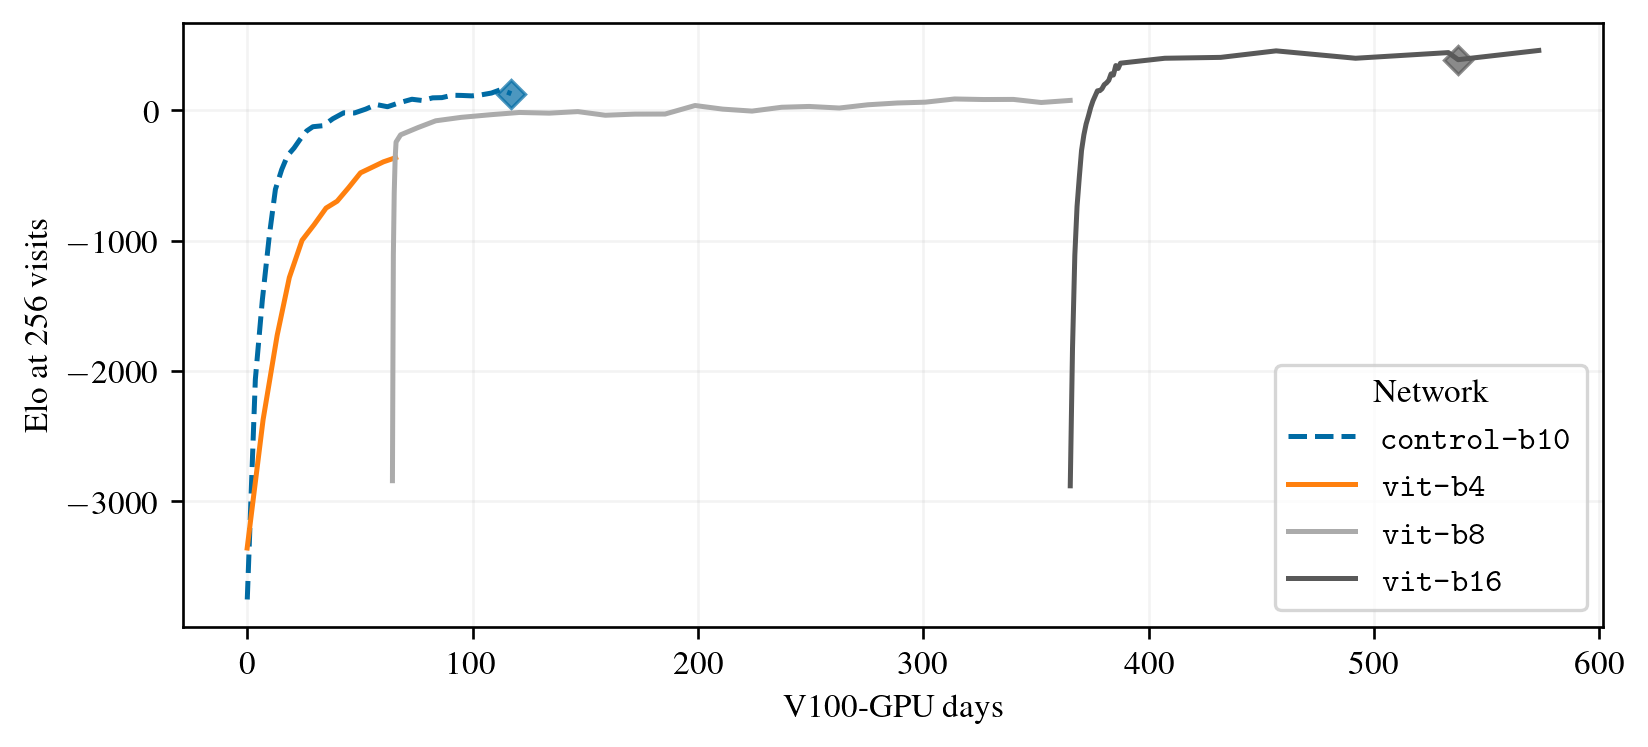

In [101]:
# (architecture, label, highlighted point step, max_steps, line_style)
architectures_to_plot = [
    ("b10", r"\texttt{control-b10}", 419465984, None, "dashed"),
    ("vit-b4", r"\texttt{vit-b4}", None, 217500000, "solid"), # vit-b4 nets above s217m are bad
    ("vit-b8", r"\texttt{vit-b8}", None, None, "solid"),
    ("vit-b16", r"\texttt{vit-b16}", 650025472, None, "solid"),
]

for architecture, _, _, _, _ in architectures_to_plot:
    architecture_df = elo_df["architecture"] == architecture
    elo_df.loc[architecture_df, "gpu_days"] = elo_df[architecture_df].apply(lambda row: gpu_days_conversions[architecture][row["steps"]], axis=1)


for x_axis_column in ["steps", "gpu_days"]:
    for is_xaxis_log_scaled in [False]:
        x_offset = 0
        for i, (architecture, label, highlighted_point_step, max_steps, line_style) in enumerate(architectures_to_plot):
            if max_steps is None:
                max_steps = float("inf")
            data_by_x = elo_df[
                (elo_df["architecture"] == architecture)
              & (elo_df["visits"] == 256)
              & (elo_df["steps"] != None)
              & (elo_df["steps"] < max_steps)
            ].groupby(x_axis_column).mean(numeric_only=True)
            data_by_x.index += x_offset
            data_by_x.elo.plot(label=label, linestyle=line_style)
            # plt.fill_between(data_by_x.index, data_by_x.elo - data_by_x.stddev, data_by_x.elo + data_by_x.stddev, alpha=0.3)
            if highlighted_point_step is not None:
                highlighted_point_x = highlighted_point_step if x_axis_column == "steps" else gpu_days_conversions[architecture][highlighted_point_step]
                highlighted_point_x += x_offset
                plt.plot(
                    highlighted_point_x,
                    data_by_x.loc[highlighted_point_x].elo,
                    "D",
                    color=COLORS[i],
                    alpha=0.7,
                )
    
            if architecture == "vit-b4":
                x_offset += VIT_B4_MAX_STEPS if x_axis_column == "steps" else gpu_days_conversions["vit-b4"][VIT_B4_MAX_STEPS]
            elif architecture == "vit-b8": 
                x_offset += VIT_B8_MAX_STEPS if x_axis_column == "steps" else gpu_days_conversions["vit-b8"][VIT_B8_MAX_STEPS]

        if is_xaxis_log_scaled:
            plt.xscale("log")
        plt.xlabel("Training steps" if x_axis_column == "steps" else "V100-GPU days")
        plt.ylabel("Elo at 256 visits")
        plt.gca().grid(True, alpha=0.15)
        # Remove ticks from the right
        plt.gca().yaxis.set_ticks_position("left")
        plt.legend(
            title="Network",
            loc="lower right",
            fancybox=True,
        )
        plt.show()

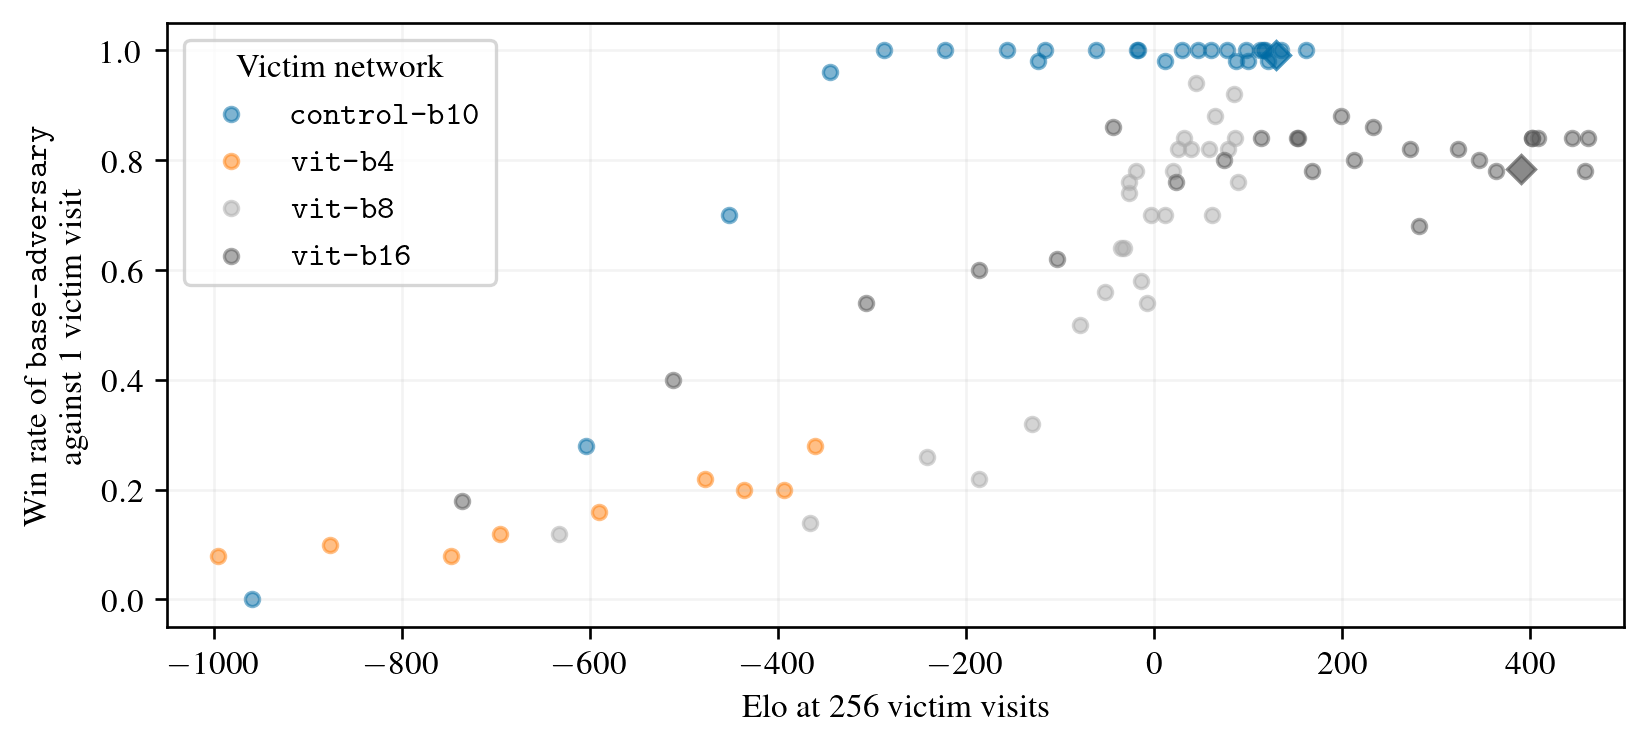

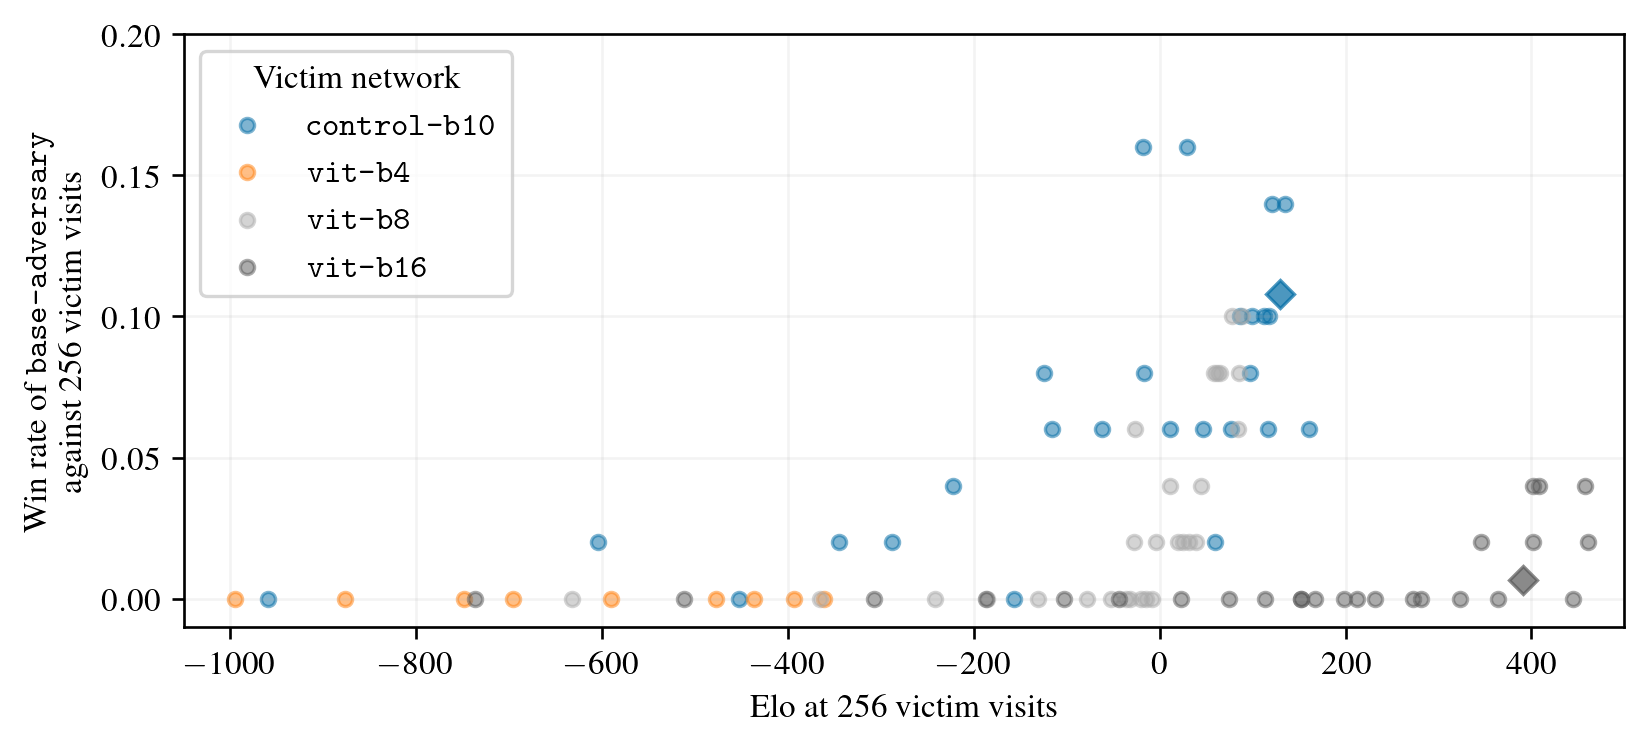

In [82]:
DEFAULT_SCATTER_POINT_SIZE = plt.rcParams['lines.markersize'] ** 2

df = pd.concat([vit_df, b10_df])


for victim_visits in [1, 256]:
    adv_win_df = df[(df["victim_visits"] == victim_visits) & (df["adv_name"] == "cyclic-s545m")].groupby(["victim_architecture", "original_victim_steps"]).adv_win.mean()
    merged_df = pd.merge(elo_df, adv_win_df, 
                         left_on=["architecture", "steps"], 
                         right_on=["victim_architecture", "original_victim_steps"], 
                         how='left')
    
    for i, (architecture, label, highlighted_point_step, max_steps) in enumerate(architectures_to_plot):
        if max_steps is None:
            max_steps = float("inf")
        data = merged_df[
            (merged_df["architecture"] == architecture)
          & (merged_df["visits"] == 256)
          & (merged_df["steps"] < max_steps)
        ]
        if highlighted_point_step is not None:
            highlighted_row = data.loc[data["steps"] == highlighted_point_step]
            plt.plot(
                highlighted_row["elo"],
                highlighted_row["adv_win"],
                "D",
                color=COLORS[i],
                alpha=0.7,
            )
            # Don't scatter plot the highlighted row.
            data = data.drop(highlighted_row.index)
        plt.scatter(x=data["elo"], y=data["adv_win"], label=label, alpha=0.5, s=(DEFAULT_SCATTER_POINT_SIZE / 2))
    
    plt.xlim(-1050, 500)
    if victim_visits == 256:
        plt.ylim(-0.01, .2)
    plt.xlabel("Elo at 256 victim visits")
    plt.ylabel(
        r"Win rate of \texttt{base-adversary}" 
        + f"\nagainst {victim_visits} victim visit"
        + ("" if victim_visits == 1 else "s")
    )
    plt.gca().grid(True, alpha=0.15)
    # Remove ticks from the right
    plt.gca().yaxis.set_ticks_position("left")
    plt.legend(
        title="Victim network",
        loc="upper left",
        fancybox=True,
    )
    plt.show()